### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [3]:
from IPython.display import Image
%matplotlib inline

# experimental script
import time
import timeit
import json
import pickle
import numpy as np
from forest_surveyor import p_count_corrected
import forest_surveyor.datasets as ds
from forest_surveyor.routines import experiment
from forest_surveyor import p_count_corrected
from forest_surveyor.structures import forest_walker, batch_getter, rule_accumulator, rule_tester, loo_encoder
from forest_surveyor.routines import tune_rf_mp, tune_rf, train_rf, evaluate_model, run_batches, forest_survey, cor_incor_forest_survey
from forest_surveyor.plotting import log_ratio_plot, plot_mean_path_lengths, plot_varimp, plot_feature_stats, rule_profile_plots

# basic setup for LIME
import lime
import lime.lime_tabular as limtab

In [4]:
alpha_scores = 0.75
for dataset in [
#                 ds.accident_small_samp_data,
                ds.adult_samp_data,
#                 ds.bankmark_samp_data,
#                 ds.car_data,
#                 ds.cardiotography_data,
#                 ds.credit_data,
#                 ds.german_data,
#                 ds.lending_tiny_samp_data,
#                 ds.nursery_samp_data,
#                 ds.rcdv_samp_data
               ]:



    # load a data set
    mydata = dataset()

    # train test split
    tt = mydata.tt_split()

    ################ PARAMETER TUNING ###################
    ############ Only runs when required ################
    #####################################################

    #nm1 = NearMiss(random_state=mydata.random_state, version=2)
    #X_resampled, y_resampled = nm1.fit_sample(tt['X_train_enc'], tt['y_train'])

    # rus = RandomUnderSampler(random_state=mydata.random_state)
    # X_resampled, y_resampled = rus.fit_sample(tt['X_train_enc'], tt['y_train'])



    # ros = RandomOverSampler(random_state=mydata.random_state)
    # X_resampled, y_resampled = ros.fit_sample(tt['X_train_enc'], tt['y_train'])
    # X_resampled, y_resampled = SMOTE().fit_sample(tt['X_train_enc'], tt['y_train'])
    # X_resampled, y_resampled = ADASYN().fit_sample(tt['X_train_enc'], tt['y_train'])

    # smote_enn = SMOTEENN(random_state=mydata.random_state)
    # X_resampled, y_resampled = smote_enn.fit_sample(tt['X_train_enc'], tt['y_train'])


    # smote_tomek = SMOTETomek(random_state=mydata.random_state)
    # X_resampled, y_resampled = smote_tomek.fit_sample(tt['X_train_enc'], tt['y_train'])



    # print(np.unique(y_resampled, return_counts=True))
    # print(np.unique(tt['y_train'], return_counts=True))


    params = tune_rf(tt['X_train_enc'], tt['y_train'],
     save_path = mydata.pickle_path(),
     random_state=mydata.random_state)

    #####################################################

    # train a rf model
    rf, enc_rf = train_rf(tt['X_train_enc'], tt['y_train'],
     params=params,
     encoder=tt['encoder'],
     random_state=mydata.random_state)

    # don't print the plots but do print the returned confusion matrix and precision, recall, F1, support measures
    if mydata.class_col in mydata.le_dict.keys():
        class_names = mydata.get_label(mydata.class_col, sorted(tt['y_train'].unique()))
    else:
        class_names = mydata.class_names

    cm, prfs = evaluate_model(prediction_model=enc_rf, X=tt['X_test'], y=tt['y_test'],
                         class_names=class_names,
                         plot_cm=False, plot_cm_norm=False)
    print('Precision: ' + str(prfs[0].tolist()))
    print('Recall: ' + str(prfs[1].tolist()))
    print('F1 Score: ' + str(prfs[2].tolist()))
    print('Support: ' + str(prfs[3].tolist()))

    # LIME

    np.random.seed(mydata.random_state)
    
    class_names=mydata.get_label(mydata.class_col, [i for i in range(len(mydata.class_names))])
    unsorted_categorical = [(v, mydata.var_dict[v]['order_col']) for v in mydata.var_dict if mydata.var_dict[v]['data_type'] == 'nominal' and mydata.var_dict[v]['class_col'] != True]
    categorical_features = [c[0] for c in sorted(unsorted_categorical, key = lambda x: x[1])]
    categorical_names = {i : mydata.var_dict[v]['labels'] for i, v in enumerate(categorical_features) if mydata.var_dict[v]['data_type'] == 'nominal' and mydata.var_dict[v]['class_col'] != True}
    


#     explainer = limtab.LimeTabularExplainer(training_data=np.array(tt['X_train'])
#                                             , feature_names=mydata.features
#                                             , training_labels=['y_train']
#                                             , class_names=class_names
#                                             , categorical_features=mydata.categorical_features
#                                             , categorical_names=categorical_names
#                                             , mode='classification'
#                                             , discretize_continuous=False
#                                             , verbose=False)

#     idx = 0
#     instance = tt['X_test'][idx:idx+1]


#     exp = explainer.explain_instance(np.array(instance)[0]
#                                      , enc_rf.predict_proba
#                                      , top_labels=4)

#     fig = exp.as_pyplot_figure(label=enc_rf.predict(instance)[0])

#     print(sorted(exp.as_list(label=enc_rf.predict(instance)[0]), key=lambda x: x[1], reverse=True))
#     print()
#     print(exp.as_list(label=enc_rf.predict(instance)[0]))
#     print()
#     print(tt['X_test'][idx:idx+1])
    


Using existing params file. To re-tune, delete file at whiteboxing\adult_samp_pickles\params.json

Best OOB Cohen's Kappa during tuning: 0.8574
Best parameters: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_depth': 16}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model



NameError: name 'evaluate_model' is not defined

In [160]:
from anchor import utils
from anchor import anchor_tabular

dataset_folder = 'C:\\Dev\\Study\\Python\\interpret_basics2\\data_source_files'
dataset = utils.load_dataset('adult', balance=True, dataset_folder=dataset_folder)

explainer = anchor_tabular.AnchorTabularExplainer(class_names=class_names.tolist(),
                                                  feature_names=mydata.features,
                                                  data=np.array(tt['X_train']),
                                                  categorical_names=categorical_names)

explainer.fit(np.array(tt['X_train']), np.array(tt['y_train']), np.array(tt['X_test']), np.array(tt['y_test']))

ValueError: column index exceeds matrix dimensions

In [147]:
# prediction
print(class_names[enc_rf.predict(instance)][0])
exp = explainer.explain_instance(np.array(instance), enc_rf.predict, threshold=0.95, desired_label=enc_rf.predict(instance)[0])

priority


IndexError: index 1 is out of bounds for axis 0 with size 1

In [10]:
tt['X_train'][0:1]

,parents,has_nurs,form,children,housing,finance,social,health
2235,0,4,0,0,1,1,0,0


In [68]:
print(rf.predict(instance)[0])
print(mydata.get_label(mydata.class_col, 1))
mydata.data.loc[tt['X_test'][idx:idx+1].index[0]]

1
priority


parents     pretentious
has_nurs         proper
form          completed
children           more
housing       less_conv
finance      convenient
social          nonprob
health         priority
decision       priority
Name: 33, dtype: object

    parents  has_nurs  form  children  housing  finance  social  health
33        1         3     1         3        2        0       0       1
[1]
[[0.    0.882 0.108 0.01 ]]
['priority']
[('has_nurs_very_crit=0', 0.17136814406185324), ('parents_great_pret=0', 0.13012770190246598), ('has_nurs_critical=0', 0.1194591005984297), ('has_nurs_proper=1', 0.10583577760025975), ('health_recommended', 0.0643703302259473), ('health_priority', 0.024271294489118262), ('children_more', -0.010508325889242947), ('parents_usual=0', -0.09855492427066927), ('health_not_recom', -0.11327376472078847), ('has_nurs_less_proper=0', -0.12409577247691898)]

[('has_nurs_very_crit=0', 0.17136814406185324), ('parents_great_pret=0', 0.13012770190246598), ('has_nurs_less_proper=0', -0.12409577247691898), ('has_nurs_critical=0', 0.1194591005984297), ('health_not_recom', -0.11327376472078847), ('has_nurs_proper=1', 0.10583577760025975), ('parents_usual=0', -0.09855492427066927), ('health_recommended', 0.06437033022594

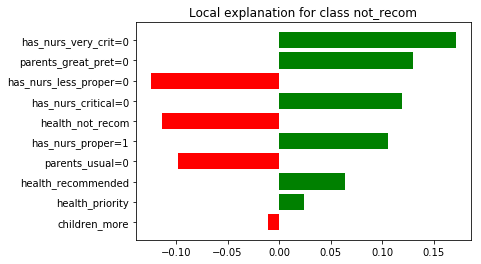

In [80]:
idx = 0

if tt['encoder'] is None:
    instance = tt['X_test'][idx:idx+1]
else:
    instance = tt['encoder'].transform(tt['X_test'][idx:idx+1]).todense()

    
print(tt['X_test'][idx:idx+1])
print(rf.predict(tt['encoder'].transform(tt['X_test'][idx:idx+1])))
print(rf.predict_proba(tt['encoder'].transform(tt['X_test'][idx:idx+1])))

print(mydata.get_label(mydata.class_col, rf.predict(tt['encoder'].transform(tt['X_test'][idx:idx+1]))))
# exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
exp = explainer.explain_instance(np.array(instance)[0]
                                 , rf.predict_proba
                                 , top_labels=1)

fig = exp.as_pyplot_figure(label=rf.predict(tt['encoder'].transform(tt['X_test'][idx:idx+1]))[0])

print(sorted(exp.as_list(label=rf.predict(instance)[0]), key=lambda x: x[1], reverse=True))
print()
print(exp.as_list(label=rf.predict(instance)[0]))
print()
print(tt['X_test'][idx:idx+1])


[('Longitude=0', 0.04123360346832207), ('1st_Road_Number', 0.013599947652392533), ('Did_Police_Officer_Attend_Scene_of_Accident', 0.012231593053766242), ('Number_of_Vehicles', 0.011589222089867153), ('Day_of_Week', 0.00824931927920942), ('1st_Road_Class', -0.0056066300848321305), ('Urban_or_Rural_Area', -0.006065337198487699), ('Speed_limit', -0.006930439595013255), ('Local_Authority_(Highway)_E10', -0.007015718891240123), ('Location_Easting_OSGR', -0.009161408573452896)]


matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  5.46045000e+05,  2.58839000e+05,
          1.35980000e-01,  5.22083860e+01,  3.50000000e+01,
          2.00000000e+00,  1.00000000e+00,  7.00000000e+00,
          3.90000000e+02,  6.00000000e+00,  0.00000000e+00,
          6.00000000e+00,  2.00000000e+01,  0.00000000e+00,
         -1.00000000e+00, -1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          2.45756451e+06]])

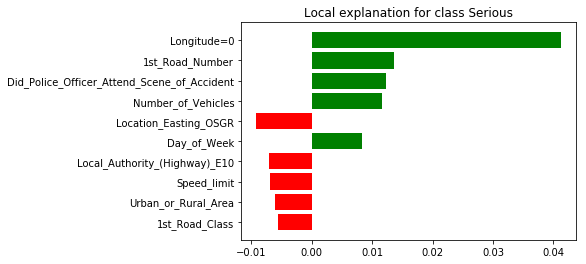

In [24]:
# exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
exp = explainer.explain_instance(np.array(instance)[0]
                                 , rf.predict_proba
                                 , top_labels=4)

fig = exp.as_pyplot_figure(label=rf.predict(instance)[0])

print(sorted(exp.as_list(label=rf.predict(instance)[0]), key=lambda x: x[1], reverse=True))
instance




In [3]:
# fit the forest_walker
f_walker = forest_walker(forest = rf,
 data_container=mydata,
 encoder=tt['encoder'],
 prediction_model=enc_rf)

# Part 1. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [4]:
# tuning params
# support - for freq patts in paths
# 0 < aplha_paths < 1 - greater favours longer rules
# sample instances and sample labels: training data, validation data, or new sample from target distribution to check for drift

# run the batch based forest walker
getter = batch_getter(instances=tt['X_test'], labels=tt['y_test'])

batch_size = 10
n_batches = 1

print('starting new run at: ' + time.asctime(time.gmtime()) + ' with batch_size = ' + str(batch_size) + ' and n_batches = ' + str(n_batches))
start_time = timeit.default_timer()

# rule_acc is just the last rule rule_accumulator, results are for the whole batch
rule_acc, results, results_sets = run_batches(f_walker=f_walker,
 getter=getter,
 data_container=mydata,
 sample_instances=tt['X_train_enc'],
 sample_labels=tt['y_train'],
 support_paths=0.1,
 alpha_paths=0.5,
 alpha_scores=0.75,
 which_trees='majority',
 greedy='plausibility',
 batch_size = batch_size,
 n_batches = n_batches)

end_time = timeit.default_timer()
print('ending run at: ' + time.asctime(time.gmtime()))

elapsed_time = end_time - start_time
print('elapsed time (seconds) = ' + str(elapsed_time))




starting new run at: Tue Apr 24 14:06:31 2018 with batch_size = 10 and n_batches = 1


C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:261: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:257: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
ending run at: Tue Apr 24 14:06:37 2018
elapsed time (seconds) = 6.4173532733578


In [ ]:
for r in range(len(results)):
    for result_set in range(6):
        instance_id = results[r][0].instance_id
        rule = results[r][result_set].pruned_rule

        looe = loo_encoder(tt['X_test'], tt['y_test'], tt['encoder'])
        instances, enc_instances, labels = looe.loo_encode(instance_id)

        rt = rule_tester(data_container=mydata, rule=rule, sample_instances=enc_instances, sample_labels=labels)
        print(instance_id)
        print(mydata.pretty_rule(rule))
        print(tt['y_test'].loc[instance_id])
        print(tt['X_test'].loc[instance_id])
        print(rt.evaluate_rule())
        print()

In [19]:
# load a data set
mydata = ds.nursery_samp_data()

# train test split
tt = mydata.tt_split()

# train a rf model
rf, enc_rf = train_rf(tt['X_train_enc'], tt['y_train'],
 params=params,
 encoder=tt['encoder'],
 random_state=mydata.random_state)

# fit the forest_walker
f_walker = forest_walker(forest = rf,
 data_container=mydata,
 encoder=tt['encoder'],
 prediction_model=enc_rf)

# run the batch based forest walker
getter = batch_getter(instances=tt['X_test'], labels=tt['y_test'])

batch_size = 2
n_batches = 1

rule_acc, results, results_sets = run_batches(f_walker=f_walker,
 getter=getter,
 data_container=mydata,
 sample_instances=tt['X_train_enc'],
 sample_labels=tt['y_train'],
 support_paths=0.1,
 alpha_paths=0.5,
 alpha_scores=0.75,
 which_trees='majority',
 greedy='plausibility',
 batch_size = batch_size,
 n_batches = n_batches)


Best OOB Cohen's Kappa during tuning: 0.8443
Best parameters: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_depth': 8}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model



C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:983: RuntimeWarning: invalid value encountered in true_divide
  f1 =  [2] * ((post * recall) / (post + recall))


done batch 0


In [580]:
res = 2
print(mydata.pretty_rule(results[batch_size - 1][res].pruned_rule))
print()

from scipy import sparse
from scipy.stats import entropy
import math
import numpy as np
class rule_tester:

    def __init__(self, data_container, rule, sample_instances):
        self.onehot_features = data_container.onehot_features
        self.rule = rule
        self.sample_instances = sample_instances
        
    def flip_rule(self, rule=None):
        if rule is None:
            rule = self.rule
        flipped_rule = [(f, ~t, v) for (f, t, v) in rule]
        return(flipped_rule)

    def apply_rule(self, rule=None, instances=None):
        if rule is None:
            rule = self.rule
        if instances is None:
            instances = self.sample_instances
        lt_gt = lambda x, y, z : x < y if z else x > y # if z is True, x < y else x > y
        idx = np.full(instances.shape[0], 1, dtype='bool')
        for r in rule:
            idx = np.logical_and(idx, lt_gt(instances.getcol(self.onehot_features.index(r[0])).toarray().flatten(), r[2], r[1]))
        return(idx)
    
    def score_not_rule(self, sample_instance, prediction_model, data_container=None, rule=None, sample_instances=None):
        
        if data_container is None:
            onehot_dict = self.onehot_dict
            var_dict = self.var_dict
        else:
            onehot_dict = data_container.onehot_dict
            var_dict = data_container.var_dict
        if rule is None:
            rule = self.rule
        if sample_instances is None:
            sample_instances = self.sample_instances
        
        print(sample_instance)
        print()
        posteriors = prediction_model.predict_proba(sample_instance)[0]
        print('P(Y = c | Rule) = Model Posterior')
        print(posteriors)
        print()
        or_positions = {} # for the FALSE case we need to test when item value instance value, create entry for each parent feature
        discontinuities = {}
        for item in rule:
            instance = sample_instance.copy()
            if item[0] in onehot_dict: # categorical
                parent_feature = onehot_dict[item[0]]
                position = var_dict[onehot_dict[item[0]]]['onehot_labels'].index(item[0])
                parent_labels = var_dict[onehot_dict[item[0]]]['labels']
                
                if ~item[1]: # item value is TRUE instance value, so test all other values and return a weighted mean
                    
                    # get normalized proabilities that feature is some other value
                    not_positions = [i for i in range(len(var_dict[onehot_dict[item[0]]]['onehot_labels'])) if i != position]
                    p_count_feature = p_count_corrected(sample_instances[parent_feature][sample_instances[parent_feature] != position], [i for i in range(len(parent_labels))])
                
                    print(position)
                    print('normalized frequencies of counterfactual values for ' + parent_feature)
                    print(p_count_feature['p_counts'])
                    print()
                    
                    mean_conditionals = [0] * len(prediction_model.predict_proba(instance)[0])
                    print('pred_proba for conditional values')
                    for npos in not_positions:
                        instance[parent_feature] = npos
                        conditionals = prediction_model.predict_proba(instance)[0]
                        mean_conditionals += conditionals * p_count_feature['p_counts'][npos]
                        print('P(Y = c | ' + parent_feature + ' = ' + parent_labels[npos] + ') = ', str(conditionals)) 
                    print('P(Y = c | ' + parent_feature + ' != ' + parent_labels[position] + ') = ', str(mean_conditionals))
                    print('KL Divergence = ' + str(entropy(pk=posteriors, qk=mean_conditionals)))
                    print()
                    
                else: # need to test when item value is instance value
                      # if more than one appears for same feature, return a weighted mean
                    instance[parent_feature] = position
                    if parent_feature not in or_positions.keys():
                        or_positions[parent_feature] = [position]
                    else:
                        or_positions[parent_feature].append(position)
            
            else: # numerical
                # find values opposite the boundaries
#                 if item[0] not in discontinuities.keys():
#                         discontinuities[item[0]] = {}
                if item[1]: # leq
                    sign = '>'
                    p_count_feature = p_count_corrected(sample_instances[item[0]] > item[2], [False, True])
                    conditional_values = sample_instances[item[0]][sample_instances[item[0]] > item[2]]
                else: # gt
                    sign = '<='
                    p_count_feature = p_count_corrected(sample_instances[item[0]] <= item[2], [False, True])
                    conditional_values = sample_instances[item[0]][sample_instances[item[0]] <= item[2]]
                print('frequency of counterfactual case for ' + item[0] + ': ' + str(p_count_feature['p_counts'][p_count_feature['labels']]))
                
                # create a testing sample with all other values held
                conditional_values.reset_index(drop=True, inplace=True)
                conditional_examples = pd.concat([instance] * len(conditional_values), ignore_index=True)
                conditional_examples.update(conditional_values)
                conditionals = enc_rf.predict_proba(conditional_examples)
                mean_conditionals = conditionals.mean(axis=0)
                print('P(Y = c | ' + item[0] + ' ' + sign + ' ' + str(item[2]) + ') = ', str(mean_conditionals))
                print('KL Divergence = ' + str(entropy(pk=posteriors, qk=mean_conditionals)))
                print()

        
        # collect up any categorical parent feature values that were tested for the counterfactual = TRUE case, get a weighted mean
        for parent_feature in or_positions:
            mean_conditionals = [0] * len(prediction_model.predict_proba(instance)[0])
            parent_labels = var_dict[parent_feature]['labels']
            # get normalised probability that feature is one of these values
            p_count_feature = p_count_corrected(sample_instances[parent_feature][sample_instances[parent_feature].isin(or_positions[parent_feature])], [i for i in range(len(parent_labels))])
            print('normalized frequencies counterfactual values for ' + parent_feature)
            print(p_count_feature['p_counts'])
            print()
            feature_values = []
            for opos in or_positions[parent_feature]:
                instance[parent_feature] = opos
                feature_values.append(parent_labels[opos])
                conditionals = prediction_model.predict_proba(instance)[0]
                mean_conditionals += conditionals * p_count_feature['p_counts'][opos]
                print('P(Y = c | ' + parent_feature + ' = ' + parent_labels[opos] + ') = ', str(conditionals)) 
            if all(p_count_feature['p_counts'] < 1.0):
                print('P(Y = c | ' + parent_feature + ' in ' + str(feature_values) + ') = ', str(mean_conditionals))
            print('KL Divergence = ' + str(entropy(pk=posteriors, qk=mean_conditionals)))
            print()
            
#         print(discontinuities)
                
    def sample_outside_j(self, sample_instance, prediction_model, data_container=None, rule=None, sample_instances=None, encoder=None):
        if data_container is None:
            onehot_dict = self.onehot_dict
            var_dict = self.var_dict
        else:
            onehot_dict = data_container.onehot_dict
            var_dict = data_container.var_dict
        if rule is None:
            rule = self.rule
        if sample_instances is None:
            sample_instances = self.sample_instances
            
        if encoder is None:
            rule_test_instances = sparse.csr_matrix(sample_instances)
        else:
            rule_test_instances = encoder.transform(sample_instances)
        
        idx = self.apply_rule(rule, rule_test_instances)
        
        #jointProbs, edges = np.histogramdd(sample_instances[idx].as_matrix(), normed=True, bins=4)
        #return(jointProbs)
        return(sample_instances[idx])
        
    def joint_dist_from_rule(self, sample_instance, prediction_model, data_container=None, rule=None, sample_instances=None, encoder=None):
        if data_container is None:
            onehot_dict = self.onehot_dict
            var_dict = self.var_dict
        else:
            onehot_dict = data_container.onehot_dict
            var_dict = data_container.var_dict
        if rule is None:
            rule = self.rule
        if sample_instances is None:
            sample_instances = self.sample_instances
            
        if encoder is None:
            rule_test_instances = sparse.csr_matrix(sample_instances)
        else:
            rule_test_instances = encoder.transform(sample_instances)
        
        n_instances = len(sample_instances)
        conditional_probs = {}
        for i in range(len(rule)):
            print(rule[:i])
            print(sum(self.apply_rule(rule[:i], rule_test_instances))/n_instances)
            
            
            
#         for item in rule:
#             if item[0] in onehot_dict: # categorical
#                 parent_feature = onehot_dict[item[0]]
#                 position = var_dict[onehot_dict[item[0]]]['onehot_labels'].index(item[0])
#                 parent_labels = var_dict[onehot_dict[item[0]]]['labels']
                
#                 if ~item[1]: # item value is TRUE instance value, so test all other values and return a weighted mean
                    
#                     # get normalized proabilities that feature is some other value
#                     not_positions = [i for i in range(len(var_dict[onehot_dict[item[0]]]['onehot_labels'])) if i != position]
#                     p_count_feature = p_count_corrected(sample_instances[parent_feature][sample_instances[parent_feature] != position], [i for i in range(len(parent_labels))])
#                     conditional_probs[parent_feature] = p_count_feature
#                     print(position)
#                     print('normalized frequencies of counterfactual values for ' + parent_feature)
#                     print(p_count_feature['p_counts'])
#                     print()
                    
#                 else: # need to test when item value is instance value
#                       # if more than one appears for same feature, return a weighted mean
#                     instance[parent_feature] = position
#                     if parent_feature not in or_positions.keys():
#                         or_positions[parent_feature] = [position]
#                     else:
#                         or_positions[parent_feature].append(position)
            
#             else: # numerical
#                 if item[1]: # leq
#                     p_count_feature = p_count_corrected(sample_instances[item[0]] > item[2], [False, True])
#                     conditional_probs[parent_feature] = p_count_feature
#                     conditional_values = sample_instances[item[0]][sample_instances[item[0]] > item[2]]
#                 else: # gt
#                     p_count_feature = p_count_corrected(sample_instances[item[0]] <= item[2], [False, True])
#                     conditional_probs[parent_feature] = p_count_feature
#                     conditional_values = sample_instances[item[0]][sample_instances[item[0]] <= item[2]]
#                 print('frequency of counterfactual case for ' + item[0] + ': ' + str(p_count_feature['p_counts'][p_count_feature['labels']]))
                
#         # collect up any categorical parent feature values that were tested for the counterfactual = TRUE case, get a weighted mean
#         for parent_feature in or_positions:
#             mean_conditionals = [0] * len(prediction_model.predict_proba(instance)[0])
#             parent_labels = var_dict[parent_feature]['labels']
#             # get normalised probability that feature is one of these values
#             p_count_feature = p_count_corrected(sample_instances[parent_feature][sample_instances[parent_feature].isin(or_positions[parent_feature])], [i for i in range(len(parent_labels))])
#             print('normalized frequencies counterfactual values for ' + parent_feature)
#             print(p_count_feature['p_counts'])
#             print()
#             feature_values = []
#             for opos in or_positions[parent_feature]:
#                 print('P(Y = c | ' + parent_feature + ' = ' + parent_labels[opos] + ') = ', str(conditionals)) 
#             if all(p_count_feature['p_counts'] < 1.0):
#                 print()
            
                
  
        

rt = rule_tester(data_container=mydata, rule=results[batch_size - 1][res].pruned_rule, sample_instances=tt['X_test'])
# rt.score_not_rule(data_container=mydata, sample_instance=tt['X_test'][batch_size - 1 : batch_size].copy(), prediction_model=enc_rf)


                        
# rt.sample_outside_j(data_container=mydata, sample_instance=tt['X_test'][batch_size - 1 : batch_size].copy(), prediction_model=enc_rf, sample_instances=tt['X_test'], encoder=tt['encoder'])
rt.sample_outside_j(data_container=mydata, rule=rt.flip_rule(results[batch_size - 1][res].pruned_rule), sample_instance=tt['X_test'][batch_size - 1 : batch_size].copy(), prediction_model=enc_rf, sample_instances=tt['X_test'], encoder=tt['encoder'])
# rt.joint_dist_from_rule(data_container=mydata, sample_instance=tt['X_test'], prediction_model=enc_rf, encoder=tt['encoder'])


        

['health_priority False', 'social_problematic True', 'parents_usual False', 'housing_convenient False', 'has_nurs_very_crit True']



,parents,has_nurs,form,children,housing,finance,social,health
1632,2,2,1,3,0,1,0,1
403,2,2,1,0,0,1,2,1
304,2,3,1,2,0,0,2,1
2110,2,3,3,2,0,1,0,1
1318,2,1,3,3,0,1,0,1
336,2,1,1,2,0,1,0,1
2359,2,3,2,2,0,0,2,1
224,2,2,0,2,0,0,2,1
2429,2,3,1,0,0,0,2,1
50,2,0,1,3,0,1,2,1


In [578]:
import numpy as np
numBins = 10  # number of bins in each dimension
# data = np.random.randn(100, 2)  # generate 100000 3-d random data points

inside_samples = rt.sample_outside_j(data_container=mydata, sample_instance=tt['X_test'][batch_size - 1 : batch_size].copy(), prediction_model=enc_rf, sample_instances=tt['X_test'], encoder=tt['encoder'])

# inside_samples.reset_index(drop=True, inplace=True)

jointProbs, edges = np.histogramdd(inside_samples.iloc[:,[0,1,2,3]].as_matrix(), bins=[2,1,4,4])
jointProbs /= jointProbs.sum()
print(jointProbs, edges)

# entropy(pk=[0.51, 0.49], qk=[0.49, 0.51])

[[[[0.05555556 0.05555556 0.05555556 0.        ]
   [0.         0.05555556 0.         0.11111111]
   [0.         0.         0.05555556 0.        ]
   [0.         0.05555556 0.         0.05555556]]]


 [[[0.         0.         0.05555556 0.05555556]
   [0.05555556 0.05555556 0.         0.11111111]
   [0.         0.05555556 0.05555556 0.05555556]
   [0.         0.         0.         0.        ]]]] [array([0. , 0.5, 1. ]), array([3.5, 4.5]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]), array([0.  , 0.75, 1.5 , 2.25, 3.  ])]


In [368]:
print('example')
example = tt['X_test'][:1].copy()
print(example)
print()
rule = results[0][6].pruned_rule
print('rule')
print(rule)
print()
print('prediction probabilities for this example')
print(enc_rf.predict_proba(example)[0])
print()

for item in rule:
    if item[0] in mydata.onehot_dict: # categorical
        parent_feature = mydata.onehot_dict[item[0]]
        
        position = mydata.var_dict[mydata.onehot_dict[item[0]]]['onehot_labels'].index(item[0])
        parent_labels = mydata.var_dict[mydata.onehot_dict[item[0]]]['labels']
        not_positions = [i for i in range(len(mydata.var_dict[mydata.onehot_dict[item[0]]]['onehot_labels'])) if i != position]
        
        if ~item[1]: # item value is instance value, test all other values
            p_count_feature = p_count_corrected(mydata.data[parent_feature][np.where(mydata.data[parent_feature] != parent_labels[position])[0]], parent_labels)
            print('normalized frequencies of other values for ' + parent_feature)
            print(p_count_feature['p_counts'])
            print()
            
            mean_conditionals = [0] * len(mydata.class_names)
            for npos in not_positions:
                example[parent_feature] = npos
                conditionals = enc_rf.predict_proba(example)[0]
                mean_conditionals += conditionals * p_count_feature['p_counts'][npos]
                print('P(Y = c | ' + parent_feature + ' = ' + parent_labels[npos] + ') = ', str(conditionals)) 
            print('P(Y = c | ' + parent_feature + ' != ' + parent_labels[position] + ') = ', str(mean_conditionals))
            print(sum(mean_conditionals))
            print()

            
        else: # only need to test when item value is instance value
            example[parent_feature] = position
            conditionals = enc_rf.predict_proba(example)[0]
            mean_conditionals = conditionals
            print('P(Y = c | ' + parent_feature + ' = ' + parent_labels[npos] + ') = ', str(conditionals))
            print()
            
        
        print(position, not_positions)
    else: #numerical
        p_count_feature = p_count_corrected(mydata.data[item[0]] <= item[2], [False, True])
        print(p_count_feature)
        # find values opposite the boundary
        if item[1]: # leq
            print('leq numerical')
            sign = '<='
            
            conditional_values = mydata.data[item[0]][mydata.data[item[0]] > item[2]]
        else:
            print('gt numerical')
            sign = '>'
            conditional_values = mydata.data[item[0]][mydata.data[item[0]] <= item[2]]
        # create a testing sample with all other values held
        conditional_examples = pd.concat([example] * len(conditional_values), ignore_index=True)
        conditional_examples.update(conditional_values)
        conditionals = enc_rf.predict_proba(conditional_examples)
        mean_conditionals = conditionals.mean(axis=0)
        print('P(Y = c | ' + item[0] + ' ' + sign + ' ' + str(item[2]) + ') = ', str(mean_conditionals))
        print()
        
        
        # print(p_count_corrected(mydata.data[item[0]] <= item[2], [False, True]))
        # p_count_feature = p_count_corrected(mydata.data[parent_feature][np.where(mydata.data[parent_feature] <= item[2])], [0,1])
        
        

example
     age  workclass  fnlwgt  education  educationnum  maritalstatus  \
356   30          2  374454         11             9              0   

     occupation  relationship  race  sex  capitalgain  capitalloss  \
356          14             3     2    1            0            0   

     hoursperweek  nativecountry  
356            40             27  

rule
[('capitalgain', True, 5368.695), ('relationship_Husband', True, 0.5), ('hoursperweek', True, 44.22188), ('maritalstatus_Married-civ-spouse', True, 0.5), ('age', True, 34.55285), ('race_White', True, 0.5)]

prediction probabilities for this example
[0.99545455 0.00454545]

{'labels': [False, True], 'p_counts': array([0.04176904, 0.95823096]), 'counts': array([  51, 1170], dtype=int64)}
leq numerical


NameError: name 'instance' is not defined

In [99]:
for cf in mydata.data.columns[mydata.categorical_features]:

    example = tt['X_test'][1:2].copy()
    example_curr = mydata.le_dict[cf].inverse_transform(example[cf])[0]
    print('testing feature: ' + cf)
    print('current value')
    print(example_curr)

    p_counts = p_count_corrected(mydata.data[cf], sorted(mydata.data[cf].unique()))

    p_count_ex = p_count_corrected(mydata.data[cf][np.where(mydata.data[cf] != example_curr)[0]], sorted(mydata.data[cf].unique()))

    print('prediction probabilities')
    print(enc_rf.predict_proba(example)[0])
    average_sp = [0] * len(mydata.class_names)
    for i, (name, freq) in enumerate(zip(p_count_ex['labels'], p_count_ex['p_counts'])):
        if name == example_curr_health:
            continue
        example[cf] = i
        print('prediction probability when ' + cf + ' is set to ' + str(i))
        print(enc_rf.predict_proba(example)[0])
        p_sp = enc_rf.predict_proba(example)[0]
        average_sp += p_sp * freq
        # print('P(spec_prior | health =', name, ') =', "{:0.4f}".format(p_sp)) 
        # print ('P(spec_prior | health != recommended) = %.2f' % average_sp)
    print(average_sp)
    print(sum(average_sp))

testing feature: parents
current value
great_pret
prediction probabilities
[0.014 0.038 0.948 0.   ]
prediction probability when parents is set to 0
[0.014 0.038 0.948 0.   ]
prediction probability when parents is set to 1
[0.012 0.054 0.934 0.   ]
prediction probability when parents is set to 2
[0.006 0.054 0.94  0.   ]
[0.00904957 0.054      0.93695043 0.        ]
1.0
testing feature: has_nurs
current value
very_crit
prediction probabilities
[0.014 0.038 0.948 0.   ]
prediction probability when has_nurs is set to 0
[0.002 0.02  0.978 0.   ]
prediction probability when has_nurs is set to 1
[0.004 0.034 0.962 0.   ]
prediction probability when has_nurs is set to 2
[0.014 0.322 0.664 0.   ]
prediction probability when has_nurs is set to 3
[0.006 0.168 0.826 0.   ]
prediction probability when has_nurs is set to 4
[0.014 0.038 0.948 0.   ]
[0.00654589 0.13711281 0.8563413  0.        ]
1.0
testing feature: form
current value
incomplete
prediction probabilities
[0.014 0.038 0.948 0.   ]
pre

In [115]:
batch_size = 5
n_batches = 1

# run the batch based forest walker
getter = batch_getter(instances=tt['X_test'], labels=tt['y_test'])

instances, labels = getter.get_next(batch_size)
instance_ids = labels.index.tolist()
# get all the tree paths instance by instance

walked = f_walker.forest_walk(instances = instances
                        , labels = labels)

# rearrange paths by instances
walked.flip()


walked.set_paths(0, which_trees='majority')
walked.discretize_paths(mydata.var_dict)
walked.set_patterns(support=0.05, alpha=0.5, sort = False)

In [45]:
# Priors for health feature
health_idx = features.index('health')
print(explainer.categorical_names[health_idx])
print(explainer.feature_frequencies[health_idx])

# normalized priors for health feature excluding 'recommended' (actual value)
priority_idx = 2
non_priority = np.delete(explainer.categorical_names[health_idx], priority_idx)
non_priority_normalized_frequencies = explainer.feature_frequencies[health_idx].copy()
non_priority_normalized_frequencies[priority_idx] = 0
non_priority_normalized_frequencies /= non_priority_normalized_frequencies.sum()
print('Normalized frequencies excluding recommended')
print(explainer.categorical_names[health_idx])
print(non_priority_normalized_frequencies)

print('Making health not equal recommended')
temp = X_test[idx:idx + 1].copy()
print('P(spec_prior) before:', "{:0.4f}".format(enc_model.predict_proba(temp)[0][3]))
average_sp = 0
for i, (name, frequency) in enumerate(zip(explainer.categorical_names[health_idx]
                                          , non_priority_normalized_frequencies)):
    if name == 'recommended':
        continue
    temp['health'] = i
    p_sp = enc_model.predict_proba(temp)[0][3]
    average_sp += p_sp * frequency
    print('P(spec_prior | health =', name, ') =', "{:0.4f}".format(p_sp)) 
print ('P(spec_prior | health != recommended) = %.2f' % average_sp)

NameError: name 'features' is not defined

In [5]:
rule_acc[0].patterns

[((('has_nurs_proper', False, 0.5),
   ('health_not_recom', True, 0.5),
   ('health_recommended', True, 0.5)),
  103,
  118.40965718640236),
 ((('has_nurs_critical', True, 0.5),
   ('has_nurs_very_crit', True, 0.5),
   ('health_recommended', True, 0.5),
   ('parents_great_pret', True, 0.5)),
  50,
  116.5211249801538),
 ((('health_not_recom', True, 0.5), ('parents_great_pret', True, 0.5)),
  176,
  113.39254213944223),
 ((('has_nurs_critical', True, 0.5),
   ('health_not_recom', True, 0.5),
   ('health_recommended', True, 0.5),
   ('parents_great_pret', True, 0.5)),
  48,
  106.03148665597126),
 ((('has_nurs_less_proper', True, 0.5),
   ('health_not_recom', True, 0.5),
   ('health_recommended', True, 0.5),
   ('parents_great_pret', True, 0.5)),
  52,
  102.58908214883687),
 ((('has_nurs_proper', False, 0.5),
   ('has_nurs_very_crit', True, 0.5),
   ('parents_pretentious', False, 0.5)),
  51,
  102.31592038271843),
 ((('has_nurs_proper', False, 0.5),
   ('health_not_recom', True, 0.5),


In [172]:
mydata.get_label('health', [0, 1])
#mydata.le_dict

C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['not_recom', 'priority'], dtype=object)

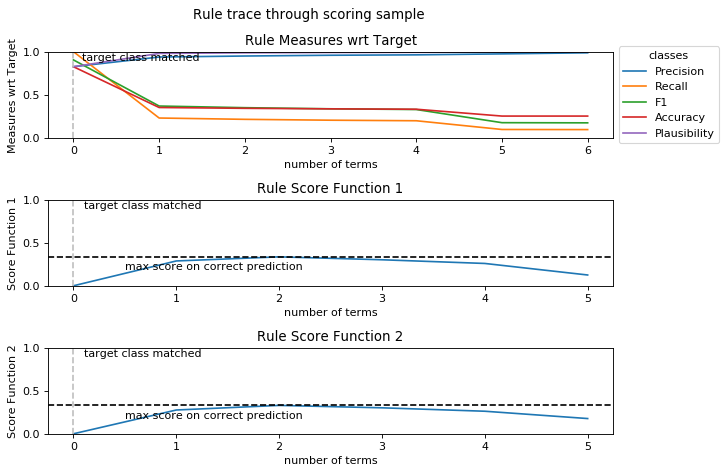

[[('Local_Authority_(District)', True, 65.63636),
  ('Day_of_Week', False, 1.57426)],
 [('Local_Authority_(District)', True, 65.63636),
  ('Day_of_Week', False, 1.57426)],
 [('Local_Authority_(District)', True, 65.63636),
  ('Day_of_Week', False, 1.57426),
  ('Location_Northing_OSGR', True, 223162.17708),
  ('Latitude', False, 51.38164),
  ('1st_Road_Number', False, 202.87805),
  ('Light_Conditions', True, 6.16102)],
 [('Local_Authority_(District)', True, 65.63636),
  ('Day_of_Week', False, 1.57426),
  ('Location_Northing_OSGR', True, 223162.17708),
  ('Latitude', False, 51.38164),
  ('1st_Road_Number', False, 202.87805),
  ('Light_Conditions', True, 6.16102)]]

In [22]:
from forest_surveyor.plotting import rule_profile_plots
i = 1
alpha_scores = 0.75
rule_profile_plots(rule_acc[i], ds.accident_small_samp_data().class_names, ig=False, cp=False, alpha_scores=alpha_scores)

[results[i][ra].pruned_rule for ra in range(4)]

In [6]:
[pr for pr in map(mydata.pretty_rule, [best_rule[r][0] for r in range(len(best_rule))])]
_ = [rule_profile_plots(rule_acc[i], ds.car_data().class_names, alpha_scores=0.5, ig=False, cp=False) for i in range(len(rule_acc))]

for r in range(len(best_rule)):
    idx = rule_acc[0].apply_rule(best_rule[r][0])
    print(mydata.pretty_rule(best_rule[r][0]), p_count(tt['y_train'].loc[idx]))

NameError: name 'best_rule' is not defined

In [42]:
mydata.pretty_rule(rule_acc[0].pruned_rule)
mydata.pickle_dir.replace('pickles', 'results')

'accident_small_samp_results'

In [9]:
[p[ra.target_class] for p in ra.pri_and_post], # should be the same as precision below
            [c[ra.target_class] for c in ra.pri_and_post_coverage],
            [a[ra.target_class] for a in ra.pri_and_post_accuracy],
            ra.precision,
            ra.isolation_pos,
            len(ra.pruned_rule),
            



[[0.6184708554125662,
  0.5397260273972603,
  0.555921052631579,
  0.5610687022900763,
  0.5337423312883436,
  1.0],
 [1.0,
  0.24112607099143207,
  0.20685434516523868,
  0.1799265605875153,
  0.10648714810281518,
  0.0073439412484700125],
 [0.6184708554125662,
  0.40348221044663135,
  0.4072672218016654,
  0.4057532172596518,
  0.3898561695685087,
  0.38607115821347465],
 [0.6184708554125662,
  0.5397260273972603,
  0.555921052631579,
  0.5610687022900763,
  0.5337423312883436,
  1.0],
 0,
 6,

# Part 2. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [4]:
# run the full forest survey
tt_correct_stats, tt_incorrect_stats = cor_incor_forest_survey(
 f_walker = f_walker, X=tt['X_test'], y=tt['y_test'])

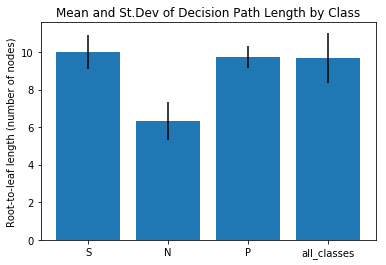

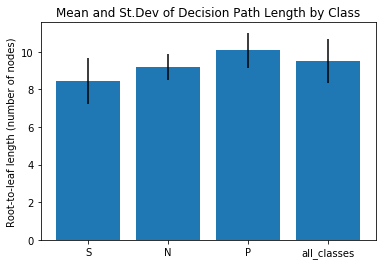

In [5]:
plot_mean_path_lengths(forest_stats=tt_correct_stats, class_names=mydata.class_names)
plot_mean_path_lengths(forest_stats=tt_incorrect_stats, class_names=mydata.class_names)

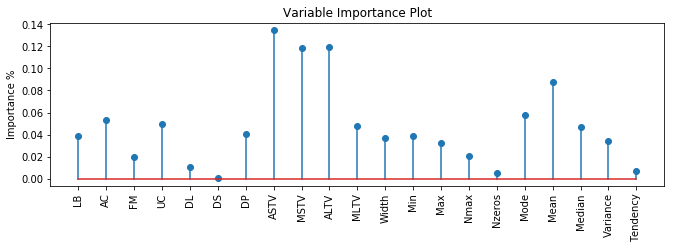

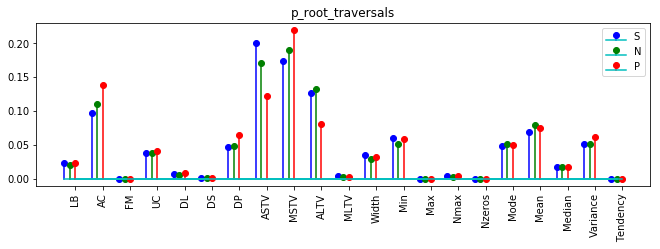

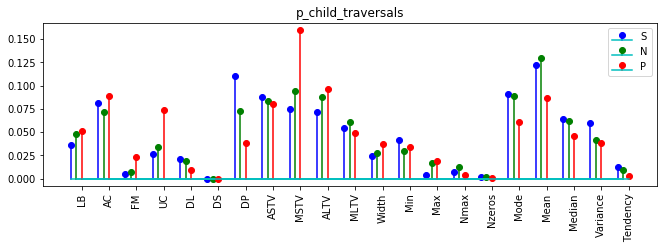

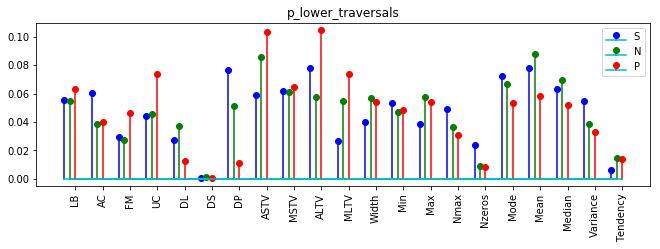

In [6]:
plot_varimp(rf, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_root_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_child_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_lower_traversals', mydata.class_names, mydata.onehot_features)

C:\dev\study\python\interpret_basics2\forest_surveyor\plotting.py:57: RuntimeWarning: invalid value encountered in true_divide
  log_ratio = np.log(num/denom)
C:\dev\study\python\interpret_basics2\forest_surveyor\plotting.py:69: RuntimeWarning: invalid value encountered in true_divide
  yerr = 0.434*np.sqrt((num_err/num)**2 + (denom_err/denom)**2)


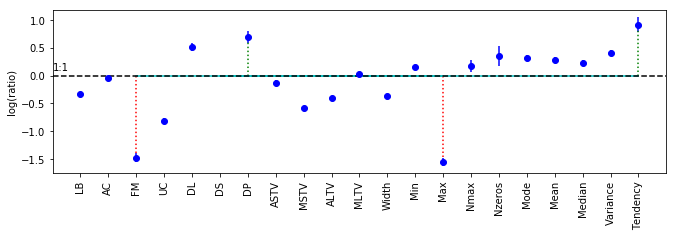

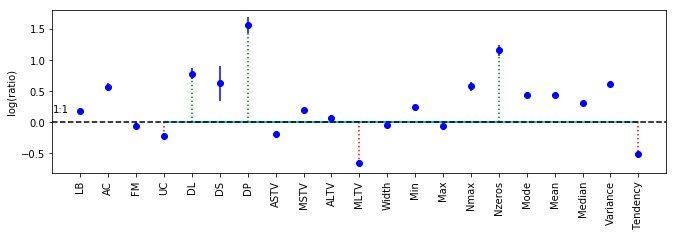

In [15]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = mydata.onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = mydata.onehot_features
)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [3]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

NameError: name 'rf' is not defined

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()

In [ ]:
%run whiteboxing_exp1.py

In [ ]:
params